# Preprocessing Images for OCR

In [3]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

## 00 - Opening an Image

In [74]:
image_file = "img/cin1.png"
img = cv2.imread(image_file)

In [83]:
def display(im_path):
    dpi = 260
    im_data = plt.imread(im_path)
    height, width  = im_data.shape[:2]
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(im_data, cmap='gray')
    plt.show()

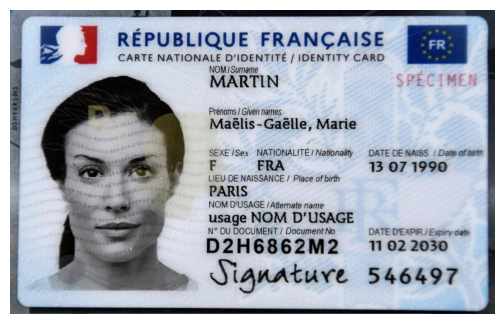

In [84]:
display(image_file)

## 01 - Denoisation

### 01.01 - Grayscale and Remove background

In [7]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [9]:
def remove_background_color(image):
    img_arr = np.array(image)
    # Convert the image to a standard RGB format if it has an alpha channel
    if img_arr.shape[2] == 4:
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGBA2RGB)
    # Get the unique colors and their counts
    colors, counts = np.unique(img_arr.reshape(-1, img_arr.shape[-1]), axis=0, return_counts=True)
    # Replace the most existing color with white
    img_arr[(img_arr == colors[np.argmax(counts)]).all(axis=2)] = [255, 255, 255]
    # Convert the NumPy array back to an image
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

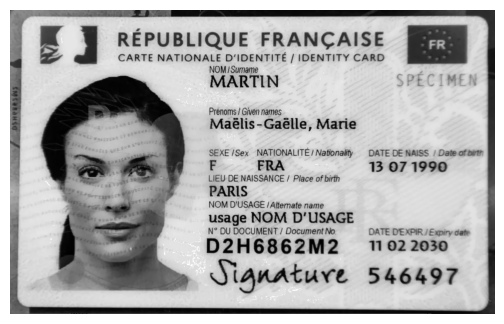

In [85]:
img_gray = cv2.bilateralFilter(grayscale(remove_background_color(img)), 8, 3, 3)
cv2.imwrite("tmp/gray.png", img_gray)
display("tmp/gray.png")

### 01.02 - Remove noise

In [10]:
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

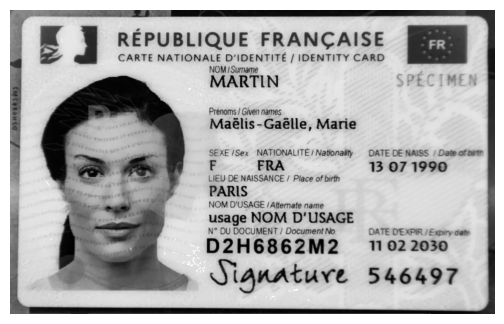

In [86]:
img_nonoise = noise_removal(img_gray)
cv2.imwrite("tmp/nonoise.png", img_nonoise)
display("tmp/nonoise.png")

### 01.03 - Thin font

In [93]:
def thin_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2, 2),np.uint8)
    image = cv2.erode(image, kernel, iterations=2)
    image = cv2.bitwise_not(image)
    return (image)

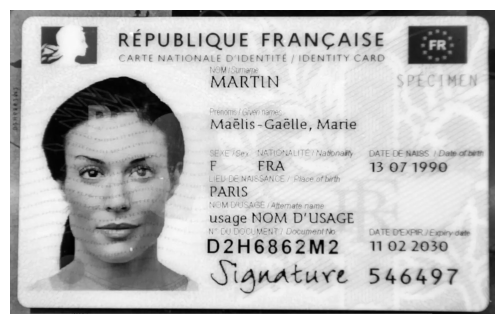

In [94]:
img_thin = thin_font(grayscale(img))
cv2.imwrite("tmp/imgthin.png", img_thin)
display("tmp/imgthin.png")

### 01.04 - Thick font

In [70]:
def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((3,3),np.uint8)
    image = cv2.dilate(image, kernel, iterations=2)
    image = cv2.bitwise_not(image)
    return (image)

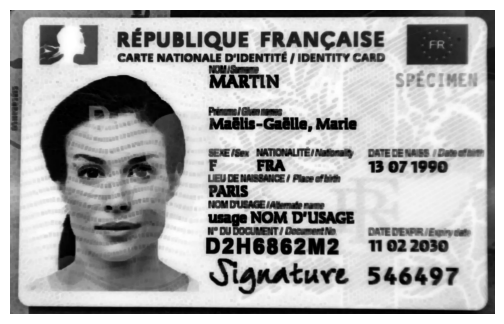

In [88]:
img_thik = thick_font(grayscale(img))
cv2.imwrite("tmp/imgthik.png", img_thik)
display("tmp/imgthik.png")

## 02 - Inclination

### 02.01 - Remove borders

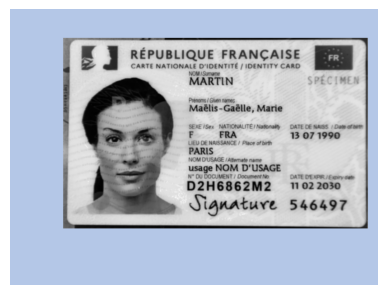

In [141]:
image_file = "img/cin3.png"
img = cv2.imread(image_file)
display(image_file)

In [125]:
def remove_borders(img):
    edged = cv2.Canny(img, 30, 200)
    plt.figure()
    plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))
    thresh, im_bw = cv2.threshold(edged, 100, 255, cv2.THRESH_BINARY)
    (x,y) = np.where(im_bw==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    return img[x1:x2+1, y1:y2+1]

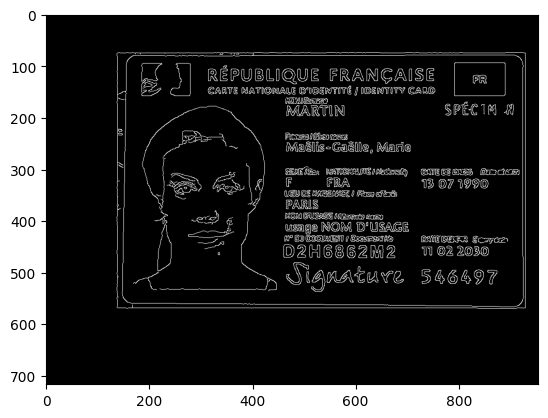

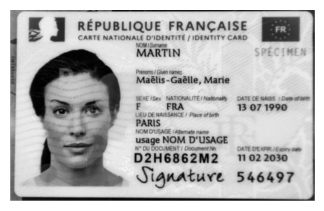

In [142]:
img_back = remove_borders(grayscale(img))
cv2.imwrite("tmp/imgback.png", img_back)
display("tmp/imgback.png")

### 02.02 - Skew angle and Deskew

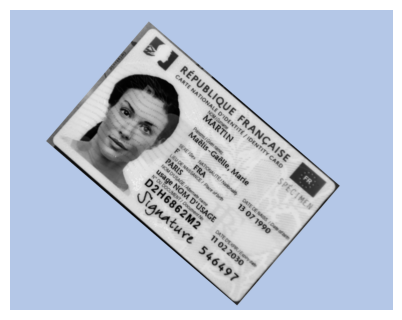

In [138]:
image_file = "img/cin2.png"
img = cv2.imread(image_file)
display(image_file)

In [117]:
def getSkewAngle(cvImage, index) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    blur = cv2.GaussianBlur(cvImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)
    #dilate = cv2.dilate(thresh, kernel, iterations=5)
    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    # Find largest contour and surround in min area box
    if index>0 and len(contours) <= 1 : 
        largestContour = contours[0]
    else : 
        largestContour = contours[index]
    minAreaRect = cv2.minAreaRect(largestContour)
    #print (len(contours))
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle > 45 :
        angle = -90 + angle
    return -1.0 * angle

In [118]:
def rotate_image(cvImage, angle: float):
    (h, w) = cvImage.shape[:2]
    if angle <= -90.0 : 
        center = ( h//2, h//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        cvImage = cv2.warpAffine(cvImage, M, (h, w), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    elif (angle >= 180.0 and angle < 270 ) or angle < 90.0 : 
        center = ( w//2, h//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        cvImage = cv2.warpAffine(cvImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    elif angle >= 90.0 or angle <= -90.0 : 
        center = ( w//2, w//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        cvImage = cv2.warpAffine(cvImage, M, (max(w, h), w), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return cvImage


In [119]:
def deskew(cvImage):
    cvImage = remove_borders(cvImage)
    angle = getSkewAngle(cvImage, 0)
    if angle < 2 and angle > -2 : 
        return cvImage
    if angle < 8 and angle > -8 : 
        angle = getSkewAngle(cvImage, 1)
        if angle < 4 and angle > -4 : 
            return remove_borders(cvImage)
    return remove_borders(rotate_image(cvImage, -1.0 * angle))

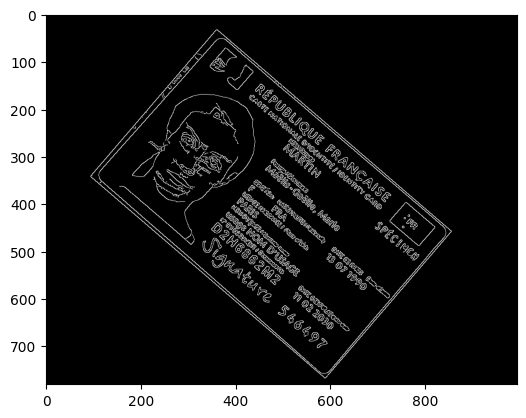

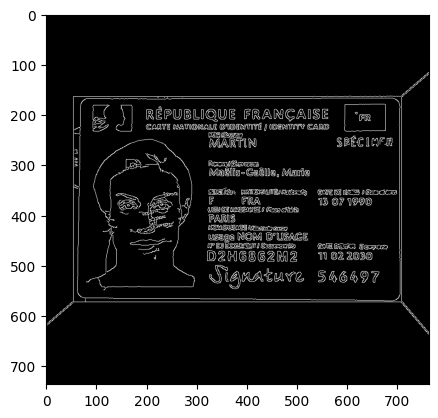

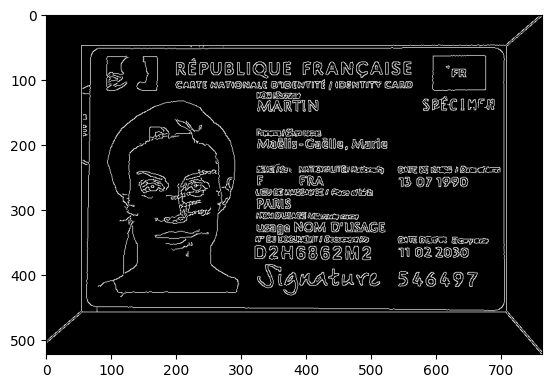

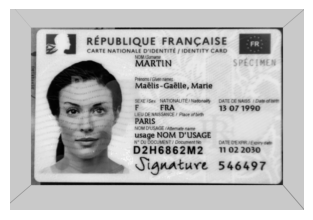

In [139]:
img_inclin = remove_borders(deskew( grayscale(img)))
cv2.imwrite("tmp/imginclin.png", img_inclin)
display("tmp/imginclin.png")

### 02.03 - Rotation

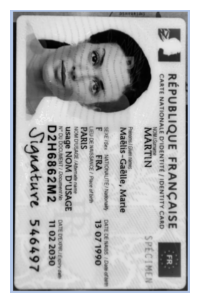

In [143]:
image_file = "img/cin4.png"
img = cv2.imread(image_file)
display(image_file)

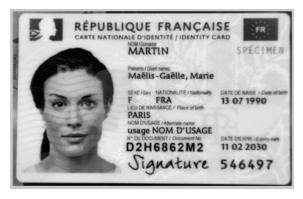

In [150]:
img_rot = rotate_image(grayscale(img), 90)
cv2.imwrite("tmp/imgrot.png", img_rot)
display("tmp/imgrot.png")

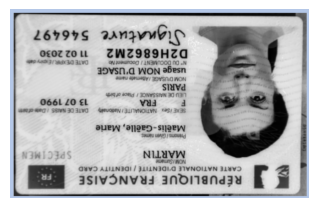

In [151]:
image_file = "img/cin5.png"
img = cv2.imread(image_file)
display(image_file)

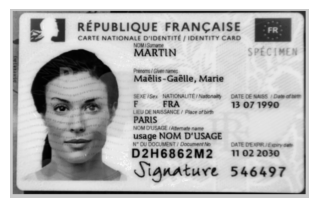

In [153]:
img_rot = rotate_image(grayscale(img), 180)
cv2.imwrite("tmp/imgrot.png", img_rot)
display("tmp/imgrot.png")

## 03 - Remove contours

In [156]:
import imutils

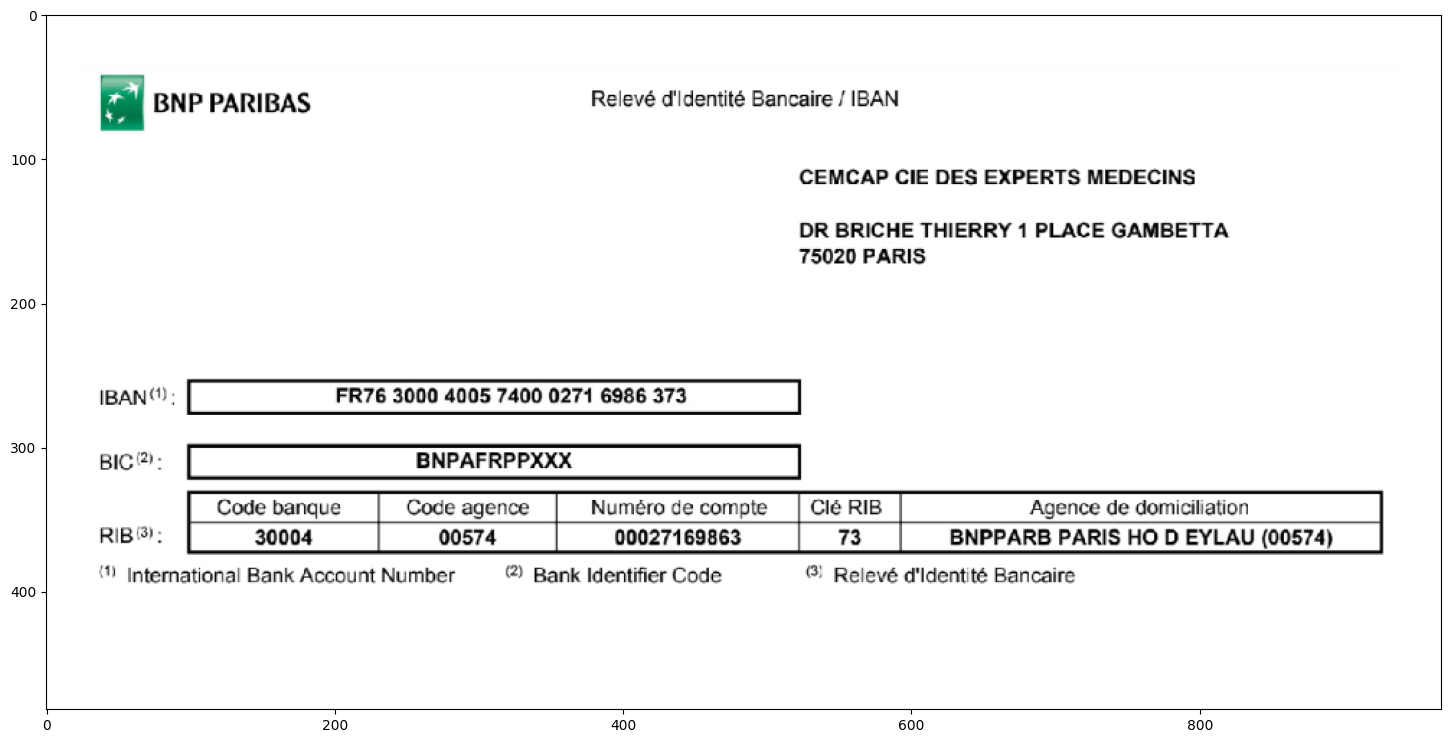

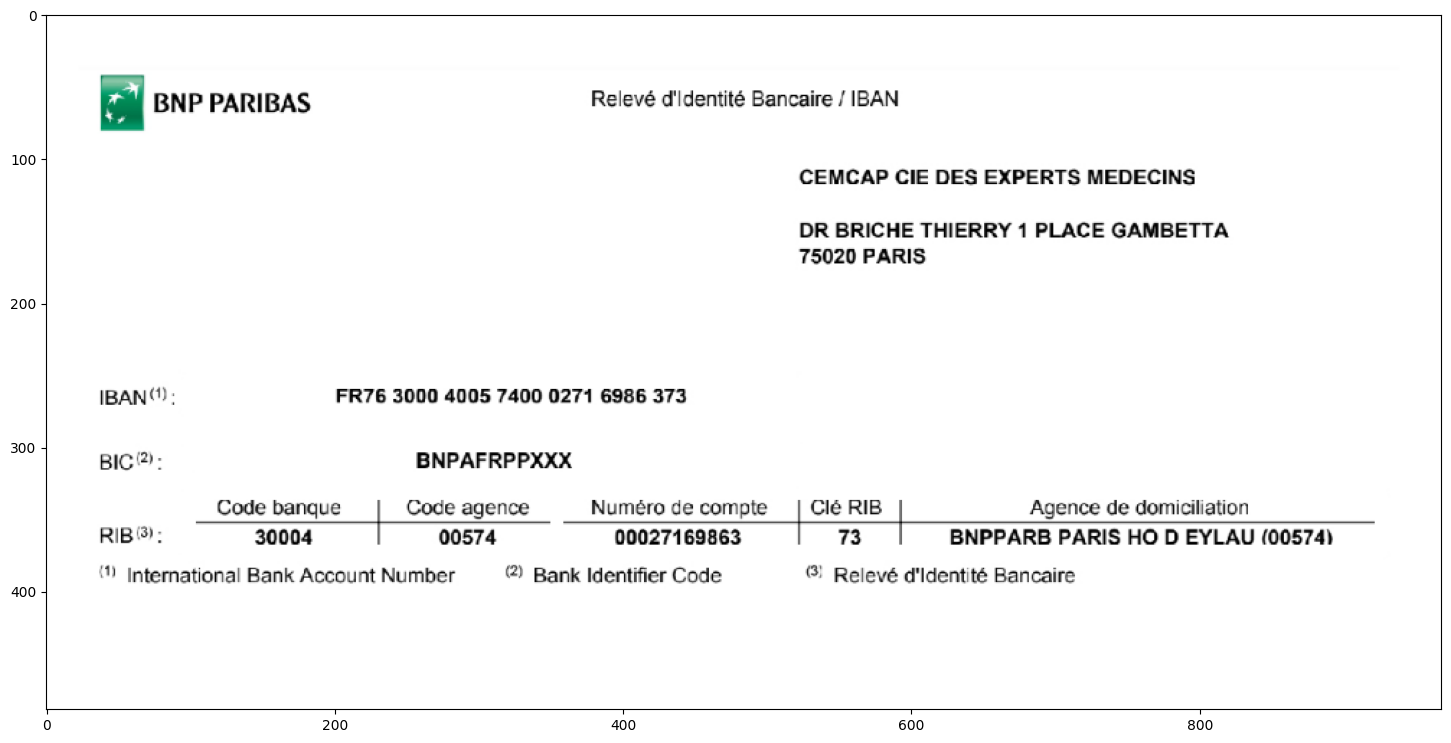

In [167]:
def remove_contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 30, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 50, 60) #Edge detection
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [approx], 0,255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)
        (x,y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (255,255,255),5)
    return res

img = cv2.imread('tmp/rib5.PNG')
plt.figure(figsize = (18,29))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
res = remove_contours(img)
plt.figure(figsize = (18,29))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))